# Qualche esempio di uso dei transformer per il NLP

Luca Mari, dicembre 2024  

Quest'opera è distribuita con <a href="http://creativecommons.org/licenses/by-nc-sa/4.0" target="_blank">Licenza Creative Commons Attribuzione - Non commerciale - Condividi allo stesso modo 4.0 Internazionale</a>.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

**Obiettivo**: essere informati di alcune possibili modalità di uso "di alto livello" dei trasformer per applicazioni con testi in lingua italiana e della libreria Python `transformers` di Hugging Face.  
**Precompetenze**: basi di Python.

> Per eseguire questo notebook con VSCode sul proprio calcolatore, occorre:
> * installare un interprete Python
> * scaricare da https://code.visualstudio.com/download e installare VSCode
> * eseguire VSCode e attivare le estensioni per Python e Jupyter
> * ancora in VSCode:
>     * creare una cartella di lavoro e renderla la cartella corrente
>     * copiare nella cartella il file di questa attività: [transformerapps.ipynb](transformerapps.ipynb)
>     * aprire il notebook `transformerapps.ipynb`
>     * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
>     * installare i moduli Python richiesti, eseguendo dal terminale:  
>         `pip install transformers torch`

Sappiamo che con sistemi come `ChatGPT` possiamo dialogare liberamente e in molte lingue. Grazie al modulo Python `transformers` di Hugging Face (https://huggingface.co/docs/transformers) e ai tanti modelli accessibili e scaricabili liberamente da Hugging Face stesso, con poche linee di codice Python è possibile costruire applicazioni con funzionalità specifiche, anche in grado di trattare testi in lingua italiana con una qualità spesso accettabile.

I modelli in questione sono spesso di dimensioni relativamente piccole, e perciò possono essere eseguiti in locale. Anche se condividono la stessa architettura di base -- perché sono tutti transformer --, sono tipicamente addestrati per applicazioni specifiche.

Nel seguito mostriamo alcuni esempi, per ognuno dei quali usiamo un modello appropriato.

Per prima cosa importiamo i moduli Python che useremo e specifichiamo che, per semplicità, faremo eseguire il codice sempre in CPU anche nel caso una GPU sia disponibile.

In [5]:
from transformers import pipeline, AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import warnings

warnings.filterwarnings("ignore")

device = "cpu"

def info(model):
    print('Modello con:')
    tokenizer = AutoTokenizer.from_pretrained(model)
    print(f'-- un vocabolario di {tokenizer.vocab_size} token')
    x = tokenizer.model_max_length
    print(f'-- un contesto di {x} token') if x < 1e12 else print('-- un contesto di lunghezza non definita')
    transformer = AutoModel.from_pretrained(model)
    model_parameters = filter(lambda p: p.requires_grad, transformer.parameters())
    y = sum([np.prod(p.size()) for p in model_parameters])
    z = f"{(y / 1e9):.2f}B" if y > 1e9 else f"{int(y / 1e6)}M"
    print(f'-- {z} parametri\n')

### 1. Part-of-Speech (POS) tagging
(modello https://huggingface.co/sachaarbonel/bert-italian-cased-finetuned-pos)

In [2]:
model = "sachaarbonel/bert-italian-cased-finetuned-pos"
info(model)
pos = pipeline("token-classification", model=model, device=device)
sentence = "Abbiamo partecipato a una lezione interessante."
res = pos(sentence)

if res is not None:
    for part in res:
        print(part)

Modello con:


Some weights of BertModel were not initialized from the model checkpoint at sachaarbonel/bert-italian-cased-finetuned-pos and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- un vocabolario di 31102 token
-- un contesto di 512 token
-- 109M parametri

{'entity': 'AUX', 'score': 0.9989906, 'index': 1, 'word': 'abbiamo', 'start': 0, 'end': 7}
{'entity': 'VERB', 'score': 0.99978894, 'index': 2, 'word': 'partecipato', 'start': 8, 'end': 19}
{'entity': 'ADP', 'score': 0.99955493, 'index': 3, 'word': 'a', 'start': 20, 'end': 21}
{'entity': 'DET', 'score': 0.99955136, 'index': 4, 'word': 'una', 'start': 22, 'end': 25}
{'entity': 'NOUN', 'score': 0.9997603, 'index': 5, 'word': 'lezione', 'start': 26, 'end': 33}
{'entity': 'ADJ', 'score': 0.99962294, 'index': 6, 'word': 'interessante', 'start': 34, 'end': 46}
{'entity': 'PUNCT', 'score': 0.9856426, 'index': 7, 'word': '.', 'start': 46, 'end': 47}


### 2. Sentiment analysis
(modello https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)

Modello con:
-- un vocabolario di 105879 token
-- un contesto di 512 token
-- 167M parametri

[{'label': '1 star', 'score': 0.004161268938332796},
 {'label': '2 stars', 'score': 0.00405264925211668},
 {'label': '3 stars', 'score': 0.04070121422410011},
 {'label': '4 stars', 'score': 0.3171132802963257},
 {'label': '5 stars', 'score': 0.6339715719223022}]


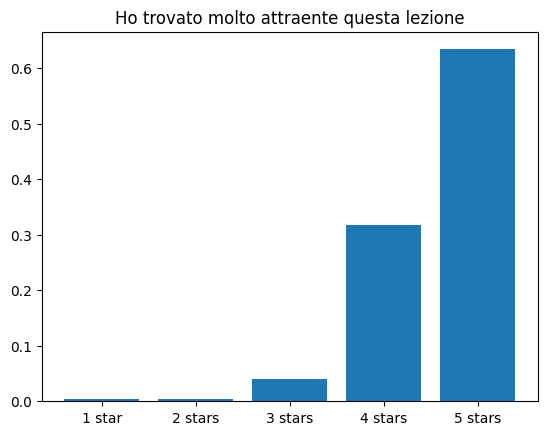

In [48]:
model = 'nlptown/bert-base-multilingual-uncased-sentiment'
info(model)
classifier = pipeline("sentiment-analysis", model=model, device=device)
sentence = "Ho trovato molto attraente questa lezione"
res = classifier(sentence, top_k=None)

if res:
    res = sorted(res, key=lambda x: x['label'])
    pprint(res)

    labels = [r['label'] for r in res]
    scores = [r['score'] for r in res]
    plt.bar(labels, scores)
    plt.title(sentence)
    plt.show()

### 3. Zero-shot classification
(modello https://huggingface.co/Jiva/xlm-roberta-large-it-mnli)

Modello con:
-- un vocabolario di 250002 token
-- un contesto di 512 token


Some weights of XLMRobertaModel were not initialized from the model checkpoint at Jiva/xlm-roberta-large-it-mnli and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- 559M parametri

[('economia', 0.07337965071201324),
 ('geografia', 0.5523250699043274),
 ('politica', 0.11166965216398239),
 ('sport', 0.049734897911548615),
 ('storia', 0.1332821547985077),
 ('tecnologia', 0.07960861176252365)]


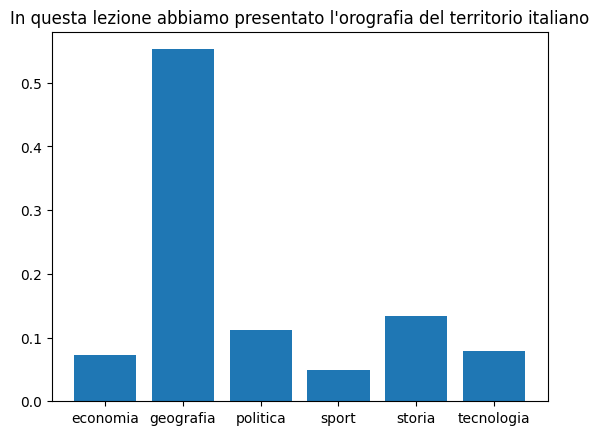

In [49]:
model = 'Jiva/xlm-roberta-large-it-mnli'
info(model)
classifier = pipeline("zero-shot-classification", model=model, device=device)
sentence = "In questa lezione abbiamo presentato l'orografia del territorio italiano"
candidate_labels = ["economia", "geografia", "politica", "sport", "storia", "tecnologia"]
res = classifier(sentence, candidate_labels=candidate_labels)

if res:
    res = zip(res['labels'], res['scores'])
    res = sorted(res, key=lambda x: x[0])
    pprint(res)

    labels = [r[0] for r in res]
    scores = [r[1] for r in res]
    plt.bar(labels, scores)
    plt.title(sentence)
    plt.show()

### 4. Named Entity Recognition (NER)
(modello https://huggingface.co/osiria/deberta-base-italian-uncased-ner)

In [50]:
model = 'osiria/deberta-base-italian-uncased-ner'
info(model)
ner = pipeline("ner", model=model, device=device, aggregation_strategy="simple")
sentence = "Questa lezione ha riguardato Alan Turing e il suo lavoro a Cambridge e poi per decodificare Enigma"
res = ner(sentence)

if res:
    print('\n', sentence, '\n')
    for entity in res:
        print(entity)

Modello con:
-- un vocabolario di 50273 token
-- un contesto di lunghezza non definita
-- 124M parametri



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



 Questa lezione ha riguardato Alan Turing e il suo lavoro a Cambridge e poi per decodificare Enigma 

{'entity_group': 'PER', 'score': 0.8034604, 'word': 'Alan Turing', 'start': 28, 'end': 40}
{'entity_group': 'LOC', 'score': 0.88072294, 'word': 'Cambridge', 'start': 58, 'end': 68}
{'entity_group': 'MISC', 'score': 0.942005, 'word': 'Enigma', 'start': 91, 'end': 98}


### 5. Fill mask
(modello https://huggingface.co/Musixmatch/umberto-wikipedia-uncased-v1)

In [51]:
model = 'Musixmatch/umberto-wikipedia-uncased-v1'
info(model)
unmasker = pipeline("fill-mask", model=model, device=device)
sentence = "In questa lezione stiamo discutendo di <mask> artificiale."
res = unmasker(sentence, top_k=3)
if res:
    print('\n', sentence, '\n')
    for fill in res:
        print(f" {fill['sequence']} ({fill['score']:0.2f})")

Modello con:
-- un vocabolario di 32004 token
-- un contesto di lunghezza non definita
-- 110M parametri



Some weights of the model checkpoint at Musixmatch/umberto-wikipedia-uncased-v1 were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 In questa lezione stiamo discutendo di <mask> artificiale. 

 n questa lezione stiamo discutendo di intelligenza artificiale. (0.77)
 n questa lezione stiamo discutendo di lingua artificiale. (0.04)
 n questa lezione stiamo discutendo di selezione artificiale. (0.01)


### 6. Question answering
(modello https://huggingface.co/osiria/deberta-italian-question-answering)

In [52]:
model = 'osiria/deberta-italian-question-answering'
info(model)
question_answerer = pipeline("question-answering", model=model, device=device)
context = """
Una rete neurale è una struttura computazionale ispirata ai neuroni del cervello umano.
È composta da strati di nodi interconnessi, chiamati neuroni,
che elaborano e trasformano i dati di input in output.
È nelle connessioni tra i neuroni che risiede la capacità di apprendimento della rete.
"""
question = """
Cosa fa sì che una rete neurale sia in grado di adattare il suo comportamento,
ottimizzandolo in funzione del contenuto del training set utilizzato nel suo addestramento?
"""
res = question_answerer({'context': context, 'question': question})

if res:
    print('Context:', context)
    print('Question:', question)
    print(res)


Modello con:
-- un vocabolario di 50255 token
-- un contesto di lunghezza non definita
-- 124M parametri

Context: 
Una rete neurale è una struttura computazionale ispirata ai neuroni del cervello umano.
È composta da strati di nodi interconnessi, chiamati neuroni,
che elaborano e trasformano i dati di input in output.
È nelle connessioni tra i neuroni che risiede la capacità di apprendimento della rete.

Question: 
Cosa fa sì che una rete neurale sia in grado di adattare il suo comportamento,
ottimizzandolo in funzione del contenuto del training set utilizzato nel suo addestramento?

{'score': 0.7373588681221008, 'start': 213, 'end': 239, 'answer': ' connessioni tra i neuroni'}


### 7. Text generation (completamento)
(modello https://huggingface.co/google/gemma-2-2b-it)

In [6]:
model = "google/gemma-2-2b-it"
info(model)
generator = pipeline("text-generation", model=model, device=device)
sentence = "In questa lezione sull'intelligenza artificiale, stiamo trattando di"
res = generator(sentence, max_length=100, truncation=False)

if res:
    pprint(res[0]['generated_text'])

Modello con:
-- un vocabolario di 256000 token
-- un contesto di lunghezza non definita


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

-- 2.61B parametri



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

("In questa lezione sull'intelligenza artificiale, stiamo trattando di un "
 "argomento molto importante e complesso: **l'etica dell'intelligenza "
 'artificiale**. \n'
 '\n'
 '**Cosa significa "etica dell\'intelligenza artificiale"?**\n'
 '\n'
 "L'etica dell'intelligenza artificiale si occupa di **determinare i principi "
 "etici che dovrebbero guidare lo sviluppo e l'utilizzo di sistemi di "
 'intelligenza artificiale**. \n'
 '\n'
 '**Perché è')


### 8. Text generation (Q&A)
(modello https://huggingface.co/google/gemma-2-2b-it)

In [7]:
model = "google/gemma-2-2b-it"
info(model)
generator = pipeline("text-generation", model=model, device=device)
system_content = "Sei un esperto che risponde in italiano. e sempre in modo amichevole."
user_content = """
    Fai una sintesi in due frasi del testo che segue?
    Il metodo scientifico ci ha insegnato a fare previsioni sulla base (1) di modelli dei fenomeni e (2) di dati: un modello ci dice che se il fenomeno è in una certa condizione, osserveremo certi effetti, e i dati ci dicono che siamo in una certa condizione; se tutto ciò è sufficientemente accurato, possiamo supporre che osserveremo proprio gli effetti predetti dal modello in base ai dati.
    Si tratta di una versione razionalizzata di ragionamenti che tutti noi, anche senza rendercene conto, attuiamo abitualmente: dall'idea, un modello appunto, che ci siamo fatti di come la nostra automobile si comporta quando freniamo e dai dati che otteniamo osservando intorno a noi mentre guidiamo, concludiamo se, quando e quanto intensamente dobbiamo schiacciare il freno.
    Ma in questo momento non abbiamo modelli affidabili di quello che sta succedendo a proposito dei sistemi cosiddetti di intelligenza artificiale generativa, e quindi questa strategia non è applicabile.
    Quando non abbiamo un modello a cui affidarci, a volte ricorriamo a una strategia di riserva: nel passato, in una certa condizione si sono prodotti certi effetti; se ora i dati ci dicono che siamo in una condizione simile, per analogia ipotizziamo che si produrranno effetti simili.
    Ragionando per analogia possiamo essere creativi, se troviamo nuove connessioni tra le entità a cui ci stiamo interessando, ma paradossalmente anche inerti di fronte ai cambiamenti, se ci ostiniamo a interpretare le novità alla luce di quello che già sappiamo.
    Ma anche questa strategia analogica non funziona oggi a proposito dei sistemi di intelligenza artificiale generativa: sia perché stiamo vivendo una condizione decisamente nuova, e quindi non sappiamo bene con cosa del passato confrontarla, sia perché le analogie sono valide quando i cambiamenti sono lineari, e invece i cambiamenti che stiamo vivendo in questi mesi sembrano proprio esponenziali.
    Insomma, se è spesso difficile fare previsioni affidabili senza modelli e dati affidabili, nella situazione in cui siamo potremmo ammettere onestamente che le nostre previsioni non hanno davvero nulla di affidabile.
"""
#res = generator([{"role": "system", "content": system_content}, {"role": "user", "content": user_content}], max_new_tokens=128)
res = generator(user_content, max_new_tokens=128)

if res:
    pprint(res[0]['generated_text'])

Modello con:
-- un vocabolario di 256000 token
-- un contesto di lunghezza non definita


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

-- 2.61B parametri



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('\n'
 '    Fai una sintesi in due frasi del testo che segue?\n'
 '    Il metodo scientifico ci ha insegnato a fare previsioni sulla base (1) '
 'di modelli dei fenomeni e (2) di dati: un modello ci dice che se il fenomeno '
 'è in una certa condizione, osserveremo certi effetti, e i dati ci dicono che '
 'siamo in una certa condizione; se tutto ciò è sufficientemente accurato, '
 'possiamo supporre che osserveremo proprio gli effetti predetti dal modello '
 'in base ai dati.\n'
 '    Si tratta di una versione razionalizzata di ragionamenti che tutti noi, '
 "anche senza rendercene conto, attuiamo abitualmente: dall'idea, un modello "
 'appunto, che ci siamo fatti di come la nostra automobile si comporta quando '
 'freniamo e dai dati che otteniamo osservando intorno a noi mentre guidiamo, '
 'concludiamo se, quando e quanto intensamente dobbiamo schiacciare il freno.\n'
 '    Ma in questo momento non abbiamo modelli affidabili di quello che sta '
 'succedendo a proposito dei sistemi c